<a href="https://colab.research.google.com/github/ordevoir/Publish/blob/master/Misc/tunneling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Упругое соударение

- Частицы моделируются кругами радиуса $R$, масса которых равна $1$.
- У каждой частицы имеется координата $\mathbf{r} = (x, y)$ и скорость $\mathbf{v}=(v_x, v_y)$.
- За временной шаг $\Delta t$ частица перемещается в соответствии со скоростью $\mathbf{r} ← \mathbf{r} + \mathbf{v}Δ t$.

Пусть $\mathbf r_1=(x_1,y_1)$, $\mathbf r_2=(x_2,y_2)$ – радиус-векторы двух частиц. Тогда расстояние между ними:

$$
d=\sqrt{\Delta x^2+\Delta y^2}
$$

In [9]:
import numpy as np

def get_distance(r1, r2):
    return np.sqrt(np.sum((r1 - r2)**2))

При соударении учитывается, что удар может быть не центральным. Вращение частиц вокруг своей оси не учитывается. Для обновления сокоростей при не центральном ударе можно произвести переход в систему координат (СК), в которой ось $Ox$ проходит через центры частиц в момент контакта. Будем называть эту систему координат собственной СК. В собственной СК упругое столкновение сводится к обмену нормальными компонентами импульсов, а касательные (тангенциальные) компоненты остаются неизменными.

Для перехода в собственную систему отсчета можно использовать матрицу преобразования:

$$
T =
\begin{bmatrix}
\cos(α)  & \sin(α) \\
-\sin(α) & \cos(α) \\
\end{bmatrix}
$$

Для того, чтобы перейти обратно в глобальную СК, можно использовать обратную матрицу:

$$
T^{(-1)} =
\begin{bmatrix}
\cos(α)  & -\sin(α) \\
\sin(α) & \cos(α) \\
\end{bmatrix}
$$

$\cos α$ $\sin α$ – комоненты вектора

$$
\mathbf{n} = \frac{\mathbf{r_1} - \mathbf{r_2}}{∣\mathbf{r_1} - \mathbf{r_2}∣}
$$

Напишем функцию, возвращающую пару матриц $T$ и $T^{(-1)}$:

In [10]:
def get_transform_pair(r1, r2, distance):
    # (защита от нулевой дистанции)
    if distance == 0:
        n = np.array([1.0, 0.0])
    else:
        n = (r1 - r2) / distance
    cos, sin = n[0], n[1]

    transform = np.array([
        [cos,  sin],
        [-sin, cos],
    ])
    reverse = np.array([
        [cos, -sin],
        [sin,  cos],
    ])
    return transform, reverse

Функция, производящая преобразование скоростей при столкновении:

In [11]:
def vels_after_collision(r1, r2, v1, v2, distance):
    transform, reverse = get_transform_pair(r1, r2, distance)

    # Переход в собственную СК
    v1_trans = np.dot(transform, v1)
    v2_trans = np.dot(transform, v2)

    # Обмен скоростями
    v1_trans[0], v2_trans[0] = v2_trans[0], v1_trans[0]

    # переход обратно в глобальную СК
    v1_reverse = np.dot(reverse, v1_trans)
    v2_reverse = np.dot(reverse, v2_trans)

    return v1_reverse, v2_reverse

Напишем функцию для одного шага.

- матрицу всех координат `rs`
- матрицу всех скоростей `vs`
- диаметр частицы `diameter`
- границы среды `bounds` (кортеж)
- ширина стены `wall_width`

Временной шаг $Δt$ примем равным $1$. Тогда обновление координаты:

$$
\mathbf{r} ← \mathbf{r} + \mathbf{v}
$$

Столкновение с внутренней стенкой регистрируется, если частица окажется между границами стенки, т.е. в стенке.

In [12]:
def one_step(rs, vs, diameter, bounds, wall_width):

    # перемещение
    rs += vs

    # столкновение с внешними стенками
    mask = np.logical_or(rs<=bounds[0], rs>=bounds[1])
    rs[mask] -= vs[mask]
    vs[mask] = -vs[mask]

    # столкновение с внутренней стенкой
    h_middle = bounds[1] // 2
    half_wall_thickness = wall_width // 2 + diameter // 2
    wall_left = h_middle - half_wall_thickness
    wall_right = h_middle + half_wall_thickness

    mask2 = np.logical_and(rs[:, 0]<=wall_right, rs[:, 0]>=wall_left)
    rs[mask2, 0] -= vs[mask2, 0]
    vs[mask2, 0] = -vs[mask2, 0]

    # соударение шариков между собой
    for i in range(len(rs)-1):
        for j in range(i+1, len(rs)):
            r1, r2, v1, v2 = rs[i], rs[j], vs[i], vs[j]
            distance = get_distance(r1, r2)
            if distance <= diameter:
                vs[i], vs[j] = vels_after_collision(r1, r2, v1, v2, distance)
                rs[i] += vs[i]
                rs[j] += vs[j]

Функция для инициализация стартовых значений координат и скоростей

In [13]:
def init_rs_vs(bounds, n_particles, velosity_factor=0.01):
    coord_values = np.linspace(bounds[0], bounds[1]//4, int(np.sqrt(n_particles)))
    rs = np.zeros((n_particles, 2), dtype=np.float16)
    counter = 0
    for i in range(int(np.sqrt(n_particles))):
        for j in range(int(np.sqrt(n_particles))):
            rs[counter] = coord_values[i], coord_values[j]
            counter += 1

    vs = np.random.uniform(-bounds[1], bounds[1], size=(n_particles, 2)) * velosity_factor
    return rs, vs

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, Circle

bounds = 0., 100.   # границы (совпадают как для X так и для Y)
wall_width = 2
N = 50              # число частиц
d = 2.

rs, vs = init_rs_vs(bounds, N, velosity_factor=0.02)

GRAY = "#333"
DARKGRAY = "#222"
figwidth = 10

# Палитра/нормализация для стабильной окраски по скорости
cmap = plt.get_cmap('hot')
speed_norm = mcolors.Normalize(vmin=0, vmax=np.linalg.norm(vs, axis=1).max() + 1e-12)

# Запуск симуляции (PyQt6)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, Circle

%matplotlib qt

fig, ax = plt.subplots()
fig.set_figwidth(figwidth)
fig.set_figheight(figwidth)
fig.set_facecolor(DARKGRAY)

rs, vs = init_rs_vs(bounds, N, velosity_factor=0.02)

# Cерая полоса-стена по центру (стена)
h_middle = (bounds[0] + bounds[1]) / 2
wall_x0 = h_middle - wall_width / 2
wall = Rectangle(xy=(wall_x0, bounds[0]), width=wall_width,
            height=bounds[1] - bounds[0],
            facecolor=DARKGRAY, edgecolor='none', zorder=0
        )

for n in range(500):
    ax.clear()
    ax.add_patch(wall)

    # Частицы как круги радиусом d/2
    colors = np.linalg.norm(vs, axis=1) # Скорости для окраски
    for (x, y), c in zip(rs, colors):
        ax.add_patch(
            Circle(
                (x, y),
                radius=d/2,
                facecolor=cmap(speed_norm(c)),
                edgecolor='none',
                zorder=1
            )
        )

    one_step(rs, vs, d, bounds, wall_width)

    ax.set_xlim(bounds)
    ax.set_ylim(bounds)
    ax.set_aspect('equal', adjustable='box')
    ax.set_facecolor(GRAY)

    # Убираем подписи и риски на осях
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.pause(0.05)

# Запуск симуляции в Colab

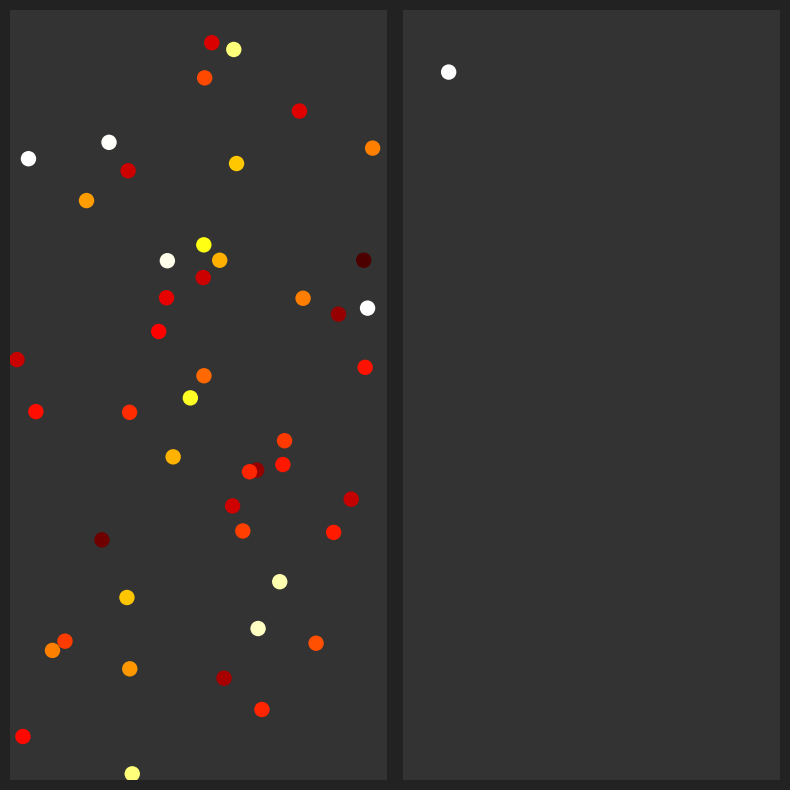

In [16]:
from matplotlib import animation
from IPython.display import HTML

%matplotlib inline

fig, ax = plt.subplots()
fig.set_figwidth(figwidth)
fig.set_figheight(figwidth)
fig.set_facecolor(DARKGRAY)

rs, vs = init_rs_vs(bounds, N, velosity_factor=0.02)

# Cерая полоса-стена по центру (стена)
h_middle = (bounds[0] + bounds[1]) / 2
wall_x0 = h_middle - wall_width / 2
wall_patch = Rectangle(
    (wall_x0, bounds[0]),
    width=wall_width,
    height=bounds[1] - bounds[0],
    facecolor=DARKGRAY, edgecolor='none', zorder=0
)
ax.add_patch(wall_patch)

# Частицы как круги радиусом d/2
circles = [Circle((rs[i, 0], rs[i, 1]), radius=d/2, edgecolor='none', zorder=1) for i in range(N)]
for circle in circles:
    ax.add_patch(circle)

ax.set_xlim(bounds)
ax.set_ylim(bounds)
ax.set_aspect('equal', adjustable='box')
ax.set_facecolor(GRAY)

# Убираем подписи и риски на осях
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
for spine in ax.spines.values():
    spine.set_visible(False)


def animate(i):
    one_step(rs, vs, d, bounds, wall_width)
    colors = np.linalg.norm(vs, axis=1) # Скорости для окраски
    for j, circle in enumerate(circles):
        circle.center = (rs[j, 0], rs[j, 1])
        circle.set_facecolor(cmap(speed_norm(colors[j])))
    return circles

anim = animation.FuncAnimation(fig, animate, frames=250, interval=50, blit=True)
HTML(anim.to_html5_video())